In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d kumaresanmanickavelu/lyft-udacity-challenge

100% 5.11G/5.11G [03:47<00:00, 27.0MB/s]
100% 5.11G/5.11G [03:47<00:00, 24.1MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/lyft-udacity-challenge.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [5]:
from keras.layers import add
from keras.layers import ReLU
from keras.layers import Layer
from keras.layers import multiply
from keras.layers import MaxPool2D
from keras.layers import UpSampling2D
from keras.layers import BatchNormalization

In [6]:
import imageio.v3 as iio

Text(0.5, 1.0, 'Segmentation')

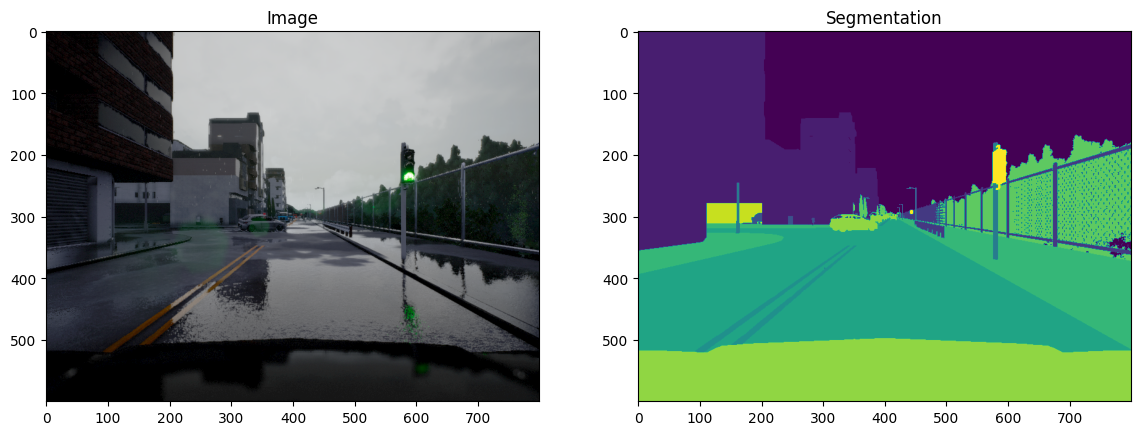

In [7]:
image_path = ('/content/dataA/dataA/CameraRGB/')
mask_path = ('/content/dataA/dataA/CameraSeg/')
test_path = ('/content/dataB/dataB/CameraRGB/')
test_mask = ('/content/dataB/dataB/CameraSeg/')
image_list = sorted(os.listdir(image_path))
mask_list = sorted(os.listdir(mask_path))
test_image_list = sorted(os.listdir(test_path))
test_mask_list = sorted(os.listdir(test_mask))
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]
test_image_list = [test_path+i for i in test_image_list]
test_mask_list = [test_mask+i for i in test_mask_list]
img =  iio.imread(image_list[12])
mask = iio.imread(mask_list[12])


fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:,:,0])
arr[1].set_title('Segmentation')

In [8]:
len(test_mask_list)

1000

In [9]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)
test_image_list_ds = tf.data.Dataset.list_files(test_image_list, shuffle=False)
test_mask_list_ds = tf.data.Dataset.list_files(test_mask_list, shuffle=False)


image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)
test_image_filenames = tf.constant(test_image_list)
test_masks_filenames = tf.constant(test_mask_list)
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_filenames, test_masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/content/dataA/dataA/CameraRGB/02_00_000.png', shape=(), dtype=string)
tf.Tensor(b'/content/dataA/dataA/CameraSeg/02_00_000.png', shape=(), dtype=string)


In [10]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) #/255

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True) #/255
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (256, 256), method='nearest')
    input_mask = tf.image.resize(mask, (256, 256), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
test_image_ds = test_dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)
test_processed_image_ds = test_image_ds.map(preprocess)

**Attention UNet**

In [11]:
class AttentionGate(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)
        
        self.filters = filters
        self.rate = rate
        self.act = ReLU()

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu')
        self.resample = UpSampling2D()
        self.c = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')        
        
    def call(self, X):
        x, skip_x = X
        
        x = self.normal(x)  
        skip = self.down(skip_x)  
        
        x = add([x, skip])  
        x = self.act(x)
        x = self.c(x)      
        x = self.resample(x)  
         
        skip_x = multiply([x, skip_x])  
        return skip_x
        
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "rate":self.rate,
        }

In [12]:
def double_conv_block(x, n_filters):

    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

In [13]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

In [14]:
def upsample_block(x, conv_features, n_filters):
    
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x) # upsample
     
    x = layers.concatenate([x, conv_features]) # concatenate
    
    x = layers.Dropout(0.3)(x)
    
    x = double_conv_block(x, n_filters)

    return x

In [15]:
def first_unet_model():

    
    inputs = layers.Input(shape=(256,256,3))

    # encoder
    
    f1, p1 = downsample_block(inputs, 64)
    
    f2, p2 = downsample_block(p1, 128)
    
    f3, p3 = downsample_block(p2, 256)
    
    f4, p4 = downsample_block(p3, 512)

    # bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder
    a1 = AttentionGate(512,0.1,name="Attention1")([bottleneck, f4])
    u6 = upsample_block(bottleneck, a1, 512)
    

    a2 = AttentionGate(256,0.1,name="Attention2")([u6, f3])
    u7 = upsample_block(u6, a2, 256)
    

    a3 = AttentionGate(128,0.1,name="Attention3")([u7, f2])
    u8 = upsample_block(u7, a3, 128)
    

    a4 = AttentionGate(64,0.1,name="Attention4")([u8, f1])
    u9 = upsample_block(u8, a4, 64)

    # output
    outputs = layers.Conv2D(23, 1, padding="same", activation = "softmax")(u9)

    
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [24]:
unet_model = first_unet_model()
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_31 (Conv2D)             (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_32 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_31[0][0]']              
                                )                                                             

In [26]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = 23,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

In [27]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[UpdatedMeanIoU(),'accuracy'])

In [28]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i])) #try , cmap='Paired'
        plt.axis('off')
    plt.show()

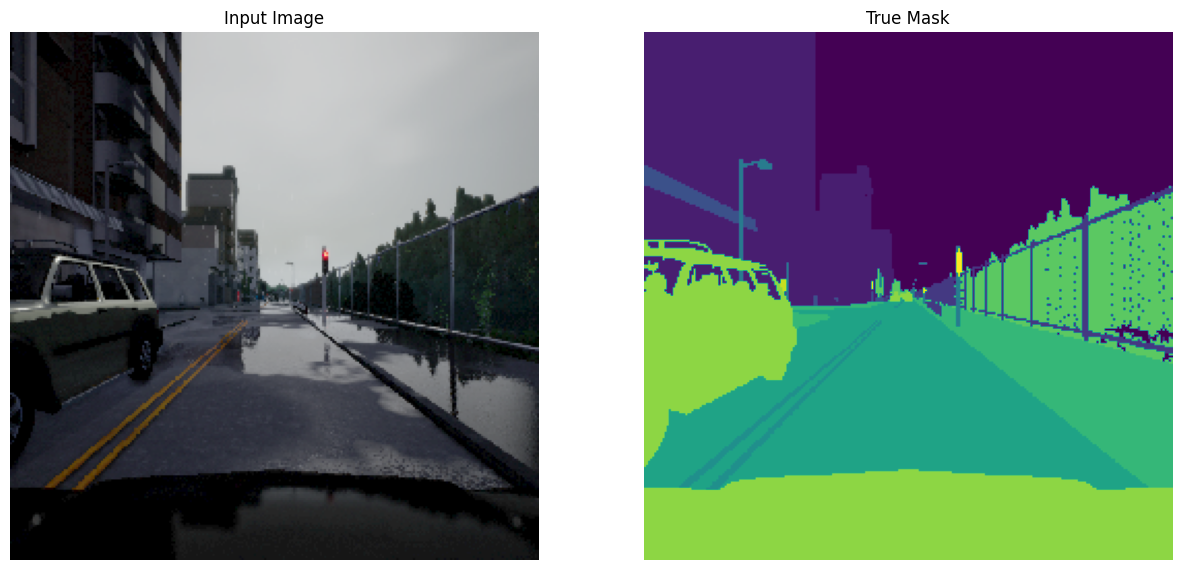

In [29]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [30]:
EPOCHS = 50
VAL_SUBSPLITS = 10
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
tests_dataset = test_processed_image_ds.cache().batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet_model.fit(train_dataset,validation_data=tests_dataset, epochs=EPOCHS)

(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))
Epoch 1/50
32/32 [==============================] - 124s 3s/step - loss: 2.2798 - updated_mean_io_u_1: 0.0287 - accuracy: 0.3395 - val_loss: 1.6970 - val_updated_mean_io_u_1: 0.1124 - val_accuracy: 0.5290
Epoch 2/50
32/32 [==============================] - 97s 3s/step - loss: 1.4338 - updated_mean_io_u_1: 0.1251 - accuracy: 0.5471 - val_loss: 1.2151 - val_updated_mean_io_u_1: 0.1609 - val_accuracy: 0.6303
Epoch 3/50
32/32 [==============================] - 99s 3s/step - loss: 1.0914 - updated_mean_io_u_1: 0.1749 - accuracy: 0.6631 - val_loss: 1.1935 - val_updated_mean_io_u_1: 0.1717 - val_accuracy: 0.6226
Epoch 4/50
32/32 [==============================] - 99s 3s/step - loss: 0.8234 - updated_mean_io_u_1: 0.2309 - accuracy: 0.7408 - val_loss: 0.7178 - val_updated_mean_io_u_1: 0.2597 - val_accuracy: 0.7696
Epoch 5/50
32/32 [==============================] - 98s 3s/s

In [31]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet_model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 392ms/step


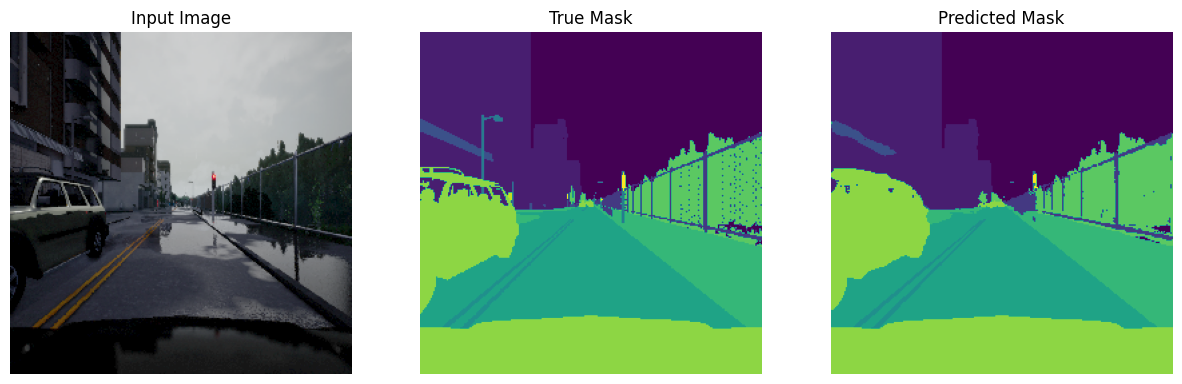

1/1 [==============================] - 0s 44ms/step


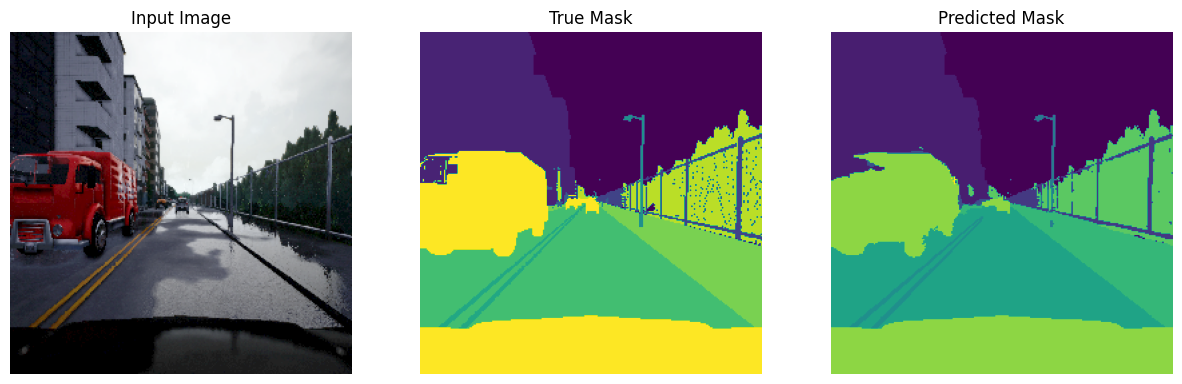

1/1 [==============================] - 0s 45ms/step


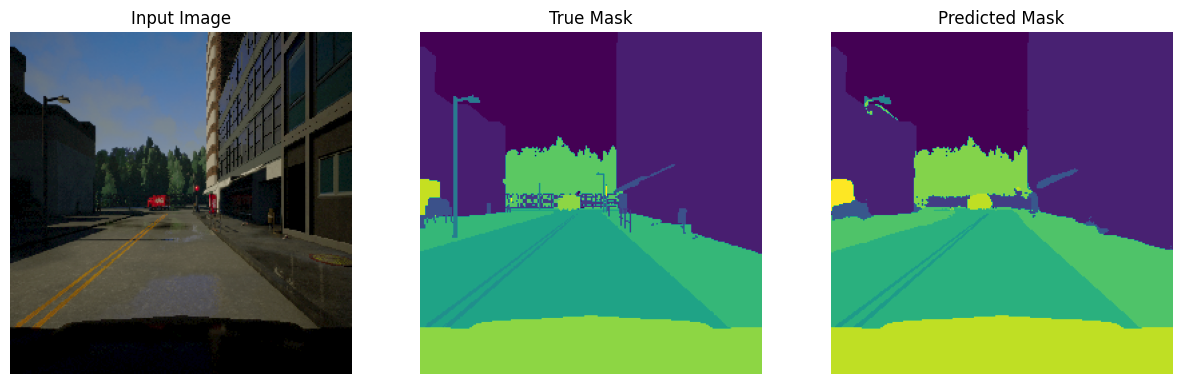

1/1 [==============================] - 0s 37ms/step


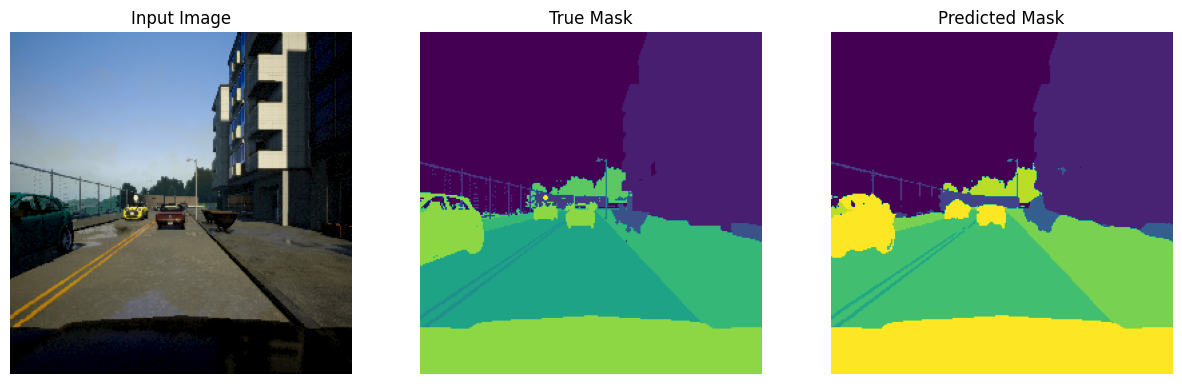

1/1 [==============================] - 0s 36ms/step


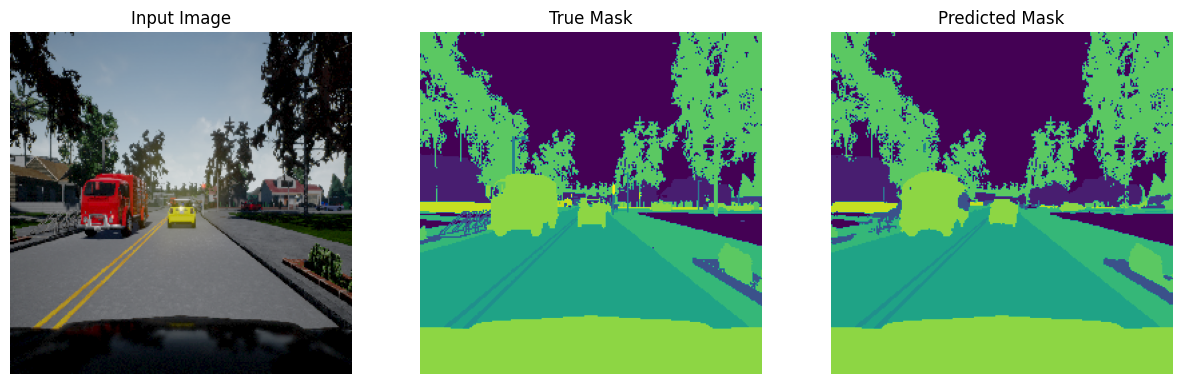

In [32]:
show_predictions(tests_dataset, 5)